In [1]:
#imports
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from scipy import stats
from keras import Sequential
from keras import Input, layers
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, LeakyReLU, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
import random
from sklearn.metrics import mean_squared_error as mse
seed_value = 2020
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
from sklearn.preprocessing import QuantileTransformer 
normalizer = QuantileTransformer(output_distribution='normal')

In [2]:
#utils functions
def midPrice(lob_data):
    a=lob_data['AP1'].values.tolist()
    b=lob_data['BP1'].values.tolist()
    m=np.zeros(len(a))
    for i in range(len(a)):
        m[i]=(a[i]+b[i])/2
    return m
def upDown(m):
    u_d=np.zeros(len(a))
    for i in range(1,len(a)):
        if m[i-1]>m[i]:#scende il prezzo
            u_d[i-1]=-1
        elif m[i-1]<m[i]:#sale il prezzo
            u_d[i-1]=1
        else:
            u_d[i-1]=0
    return u_d

def ret(m):
    r=np.zeros(len(m))
    for i in range(1,len(m)):
        r[i]=m[i-1]-m[i]
    return r

def deltaT(m):
    N=0
    d=np.zeros(len(m))
    for i in range(1,len(m)):
        d[i]=m[i-1]-m[i]
        if [i]!=0:
            N+=1
    return int((2.34*10**7)/N)

def doHk(deltT,k):
    hk=np.zeros(k)
    for i in range(k):
        hk[i]=np.int16((1/5)*i*deltT)
    return hk

def retHk(m,hk):
    ret=np.zeros(100)
    for i,k in zip(range(len(m)),hk):
        ret[i]=m[i+k]-m[i]
    return ret

def OF_1(ld):
    of=np.zeros((len(ld),6))
    for i,ii in zip(range(1,12,2),range(0,6,2)): #giro sui prezzi ask e volumi ask di conseguenza
        for j in range(1,len(ld)): #giro sulle righe
            #ask
            if ld[j][i-1]>ld[j-1][i-1]: #p_t>p_t-1
                of[j-1][ii]=-1*ld[j][i]
            elif ld[j][i-1]<ld[j-1][i-1]: #p_t<p_t-1
                of[j-1][ii]=ld[j][i]
            elif ld[j][i-1]==ld[j-1][i-1]: #p_t=p_t-1
                of[j-1][ii]=ld[j][i]-ld[j-1][i]
    for w,ww in zip(range(3,12,4),range(1,7,2)):
        for jj in range(1,len(ld)):    
            #bid
            if ld[jj][w-1]>ld[jj-1][w-1]: #p_t>p_t-1
                of[jj-1][ww]=ld[jj][w]
            elif ld[jj][w-1]<ld[jj-1][w-1]: #p_t<p_t-1
                of[jj-1][ww]=-1*ld[jj][w]
            elif ld[jj][w-1]==ld[jj-1][w-1]: #p_t=p_t-1
                of[jj-1][ww]=ld[jj][w]-ld[jj-1][w]
    return of
    
from scipy import stats
def taglia_e_cuci(v):
    hi=np.quantile(v,0.005)
    lo=np.quantile(v, 0.995)
    b=np.clip(v, hi,lo)
    z=normalizer.fit_transform((b.values.reshape(-1,1))).flatten().tolist()
    return b

def MSEbmk(r):
    rBar=np.mean(r)
    h=[ 22, 44, 89, 133, 178, 223, 267, 312, 356, 401]
    emq=np.empty(len(h))
    for i,ii in zip(range(1,len(r)),h):
        emq[i]=((rBar-r[0,ii])/rBar)**2#*(1/(len(r)-1))
    return emq

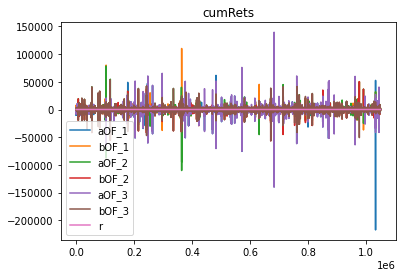

In [3]:
#load data e fa midprice/diff cum
lob_data=pd.read_csv('/Users/macri/Desktop/out_1.csv') #out_1 out_Nuovo
lob_data.reset_index(drop=True,inplace=True)
lob_data.drop(['index'], axis=1,inplace=True)
C= int(len(lob_data))
b=lob_data.iloc[ :C].copy()
ld=b.values.tolist()
lob_data=b
ld=lob_data.values.tolist()
aa=OF_1(ld) #fa Order Flow
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(aa, columns=bCols)
m=pd.DataFrame(midPrice(lob_data),columns=['m'])#.plot()
m['r']=m['m'].pct_change()#diff()#calcola le differenze di midprice ogni 10 eventi ->differenze secondo il vettore h_K
m['rCum']=m['r'].cumsum()
of_data['r']=m['rCum']#*100
of_data.dropna(inplace=True)
of_data.plot()
plt.title('cumRets')
plt.show()

In [4]:
offlo=of_data.apply(lambda x: taglia_e_cuci(x))

In [5]:
#fa dataset
y=offlo['r'].to_numpy()
idx=10000
horiz=1
r=np.empty((idx,horiz))
med=np.empty((idx,horiz))
h=[ 22]#, 44, 89, 133, 178, 223, 267, 312, 356, 401]

for i in range(idx): #righe
    for ii,iii in zip(range(horiz),h): #colonne, steps
        r[i,ii]=y[i+iii]-y[i]
        med[i][ii]=np.mean(y[:i+iii])

x_vec=offlo[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']][:1000000]
x=x_vec.to_numpy()
x_vecc=x.reshape(-1,100, 6)
erre=r

r.shape, x_vecc.shape, med.shape

((10000, 1), (10000, 100, 6, 1), (10000, 1))

In [6]:
#fa supervised dataset: train, val e test
#l=len(x_vecc)
#a=int(9000)
#b=int(999)
#x_vecc_train=x_vecc[:a]
#r_train     =r[:a]
#x_vecc_val  =x_vecc[a:a+b]
#r_val       =r[a:a+b]
#x_vecc_test =x_vecc[a+b:a+b+1]
#r_test      =r[a+b:a+b+1]
#print(x_vecc_train.shape, r_train.shape)
#print(x_vecc_val.shape,   r_val.shape)
#print(x_vecc_test.shape,  r_test.shape)
#
#fa supervised dataset: train, val e test
l=len(x_vecc)
a=int(9000)
b=int(999)
x_vecc_train=x_vecc[:a]

mu=x_vecc_train.mean()
sd=x_vecc_train.std()
stdize=lambda x: x/sd


x_vecc_train=x_vecc[:a]/sd
r_train     =r[:a]
x_vecc_val  =x_vecc[a:a+b]/sd
r_val       =r[a:a+b]
x_vecc_test =x_vecc[a+b:a+b+1]/sd
r_test      =r[a+b:a+b+1]

#fflo=of_data.apply(lambda x: (x-x.mean())/x.std())
print(x_vecc_train.shape, r_train.shape)
print(x_vecc_val.shape,   r_val.shape)
print(x_vecc_test.shape,  r_test.shape)


(9000, 100, 6, 1) (9000, 1)
(999, 100, 6, 1) (999, 1)
(1, 100, 6, 1) (1, 1)


In [7]:
#architettura della rete
num_units = 64
activation_function = 'leaky_relu'
adam = keras.optimizers.Adam(learning_rate=0.0001)
loss_function = 'mse'
batch_size = 250
num_epochs = 50
i = Input(shape=(100, 6))
x = LSTM(64, return_sequences=True)(i)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = keras.layers.Dropout(0.5)(x, training=True)
#x = LSTM(64, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='leaky_relu')(x)


model = Model(i, x)


callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

model.compile(optimizer = adam, loss = loss_function)

r=model.fit(x_vecc_train, r_train, batch_size = batch_size, epochs = num_epochs,validation_data=(x_vecc_val, r_val),callbacks=[callback])

Epoch 1/50
36/36 [==============================] - 11s 245ms/step - loss: 0.0021 - val_loss: 1.8536e-04
Epoch 2/50
36/36 [==============================] - 11s 307ms/step - loss: 1.7429e-04 - val_loss: 1.0346e-04
Epoch 3/50
36/36 [==============================] - 11s 301ms/step - loss: 9.1131e-05 - val_loss: 7.1864e-05
Epoch 4/50
36/36 [==============================] - 11s 298ms/step - loss: 7.6398e-05 - val_loss: 6.8818e-05
Epoch 5/50
36/36 [==============================] - 13s 351ms/step - loss: 7.0705e-05 - val_loss: 7.0787e-05
Epoch 6/50
36/36 [==============================] - 14s 393ms/step - loss: 6.6808e-05 - val_loss: 6.4292e-05
Epoch 7/50
36/36 [==============================] - 14s 381ms/step - loss: 6.3355e-05 - val_loss: 5.4688e-05
Epoch 8/50
36/36 [==============================] - 14s 385ms/step - loss: 5.8902e-05 - val_loss: 5.2238e-05
Epoch 9/50
36/36 [==============================] - 16s 436ms/step - loss: 5.6230e-05 - val_loss: 4.7325e-05
Epoch 10/50
36/36 [====

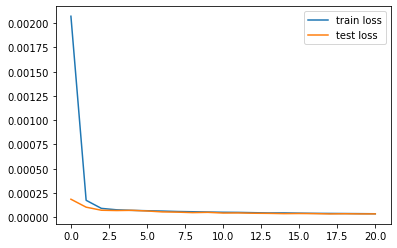

In [16]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()
plt.show()

In [17]:
Ptrain= model.predict(x_vecc_train)
Ptest = model.predict(x_vecc_test)


1/1 [==============================] - 0s 17ms/step


In [10]:
#erre=np.hstack(r_test,r_train,r_train)

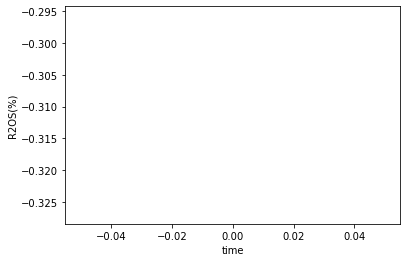

In [18]:
true=r_test#normalizer.inverse_transform(r_test.reshape(-1,1)).flatten()
fcst=Ptest#normalizer.inverse_transform(Ptest.reshape(-1,1)).flatten()
#u=np.array([np.mean(true)]*10).flatten()
num=(true-fcst)**2
den=(erre[0][-1:].flatten()-med[0])**2
r2OutS=((den-num)/den)/100+0.1
plt.plot(r2OutS[0])
plt.ylabel('R2OS(%)')
plt.xlabel('time');

In [12]:
true,fcst

(array([[0.00066824]]), array([[0.01593022]], dtype=float32))

In [21]:
r2OutS*100#+0.1 #array([[-0.21134821]])

array([[-31.1348207]])

In [14]:
erre[-1:]

array([[0.00066824]])

In [15]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
def calcola_mse(y_true,y_pred):
    ms=np.zeros(10)
    for i in range(10):
        ms[i]=mse(y_true[:i+1],y_pred[:i+1])
    return ms
r2os=1-calcola_mse(true,fcst)/np.abs((true-u))**2
r2osVero=pd.DataFrame(r2os.flatten()/100,columns=['r2'])
r2osVero[:3].plot();


ValueError: y_true and y_pred have different number of output (1!=10)

In [ ]:
#r2os=1-mse(true,fcst)/np.abs((r_test-u))**2
#r2osVero=pd.DataFrame(r2os.flatten(),columns=['r2'])

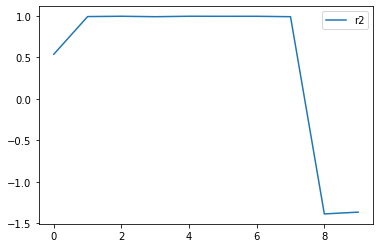

In [ ]:
#r2osVero.plot();

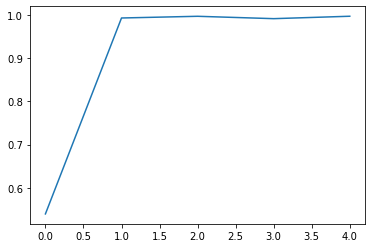

In [ ]:
#plt.plot(r2osVero.flatten()[:5]*100);

In [ ]:
#mse(true,fcst)/mse(true,u)/100

0.08454189981073391

In [ ]:
#normalizer.inverse_transform(med[a+b:a+b+1].reshape(-1,1))


array([[-0.00129964],
       [-0.0013108 ],
       [-0.00133328],
       [-0.00135325],
       [-0.00137768],
       [-0.0014031 ],
       [-0.00142484],
       [-0.00144567],
       [-0.0014644 ],
       [-0.00148314]])

In [ ]:
#def calcola_mse(y_true,y_pred):
#    ms=np.zeros(10)
#    for i in range(10):
#        ms[i]=mse(y_true[0][:i+1],y_pred[0][:i+1])
#    return ms
#num=calcola_mse(r_test,Ptest)
#
#
#1-num/np.abs((r_test-med[a+b:a+b+1]))**2

array([[0.99999798, 0.99999751, 0.99999584, 0.99999528, 0.99999592,
        0.99999644, 0.99999615, 0.99999584, 0.99999588, 0.99999582]])

In [ ]:
#from sklearn.metrics import mean_squared_error as me
#def calcola_mse(y_true,y_pred):
#    ms=np.zeros(10)
#    for i in range(10):
#        ms[i]=me(y_true[0][:i+1],y_pred[0][:i+1])
#    return ms
#num=calcola_mse(r_test,Ptest)
#den=calcola_mse(r_test,m)
#r2LSTMSFT=1-(den/num)
#r2LSTMSFT.flatten()
#plt.plot(r2LSTMSFT);

In [ ]:
#from sklearn.metrics import mean_squared_error as me
#def calcola_mse(y_true,y_pred):
#    ms=np.zeros(10)
#    for i in range(10):
#        ms[i]=me(y_true[0][:i+1],y_pred[0][:i+1])
#    return ms
#num=calcola_mse(r_test,Ptest)

In [ ]:
#1-num/np.abs((r_test-med[a+b:a+b+1]))**2/10
#
#r2os=1-num/np.abs((r_test-med[a+b:a+b+1]))**2/10
#rqua=pd.DataFrame(r2os.flatten(),columns=['r2'])

In [ ]:
#mmmm=med[a+b:a+b+1].flatten()
#rrrr=r_test.flatten()

In [ ]:
#(rrrr[0]-mmmm[0])**2/22

In [ ]:
#np.abs(rrrr[0]-mmmm[0])

In [ ]:
#r2oss=[]#np.empty(10)
#for i,ii in zip(range(10),h):
#    r2oss.append(np.abs((rrrr[i]-mmmm[i])))
#r2oss

In [ ]:
#num/r2oss

In [ ]:
#rqua.pct_change()

In [ ]:
#np.mean(r_test)

In [ ]:
#def calcola_mse1(y_true,y_pred):
#    ms=np.zeros(10)
#    for i in range(10):
#        ms[i]=y_true[:i+1]-y_pred[:i+1]
#    return ms

In [ ]:
#rr=[np.mean(r_test[:22])]*10
#rbar=np.array(rr)
#rbarr=rbar.reshape(1,10)

In [ ]:
#np.mean(r_test[:44])

In [ ]:

#r2os=num/np.abs((r_test-m[a+b:a+b+1]))**2
#rqua=pd.DataFrame(r2os.flatten(),columns=['r2'])

In [ ]:
#r_test

array([[0.02352666, 0.03466294, 0.04089188, 0.03362436, 0.00812196,
        0.01027818, 0.03986261, 0.03363091, 0.02520861, 0.02521092]])

In [ ]:
#

NameError: name 'rqua' is not defined

In [ ]:
#rqua

,r2
0,0.367025
1,0.541543
2,0.667238
3,0.515501
4,0.130159
5,0.160504
6,0.640032
7,0.508892
8,0.384440
9,0.383253


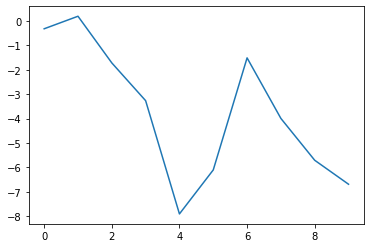

In [ ]:
#plt.plot(r2os.flatten());

In [ ]:
#mse(r_test,m[a+b:a+b+1])

4.157332652398157e-06

In [ ]:
#m[a+b:a+b+1].flatten()

array([-0.00106693, -0.001079  , -0.00110332, -0.00112477, -0.00115045,
       -0.00117676, -0.00119976, -0.00122245, -0.00124592, -0.00126979])

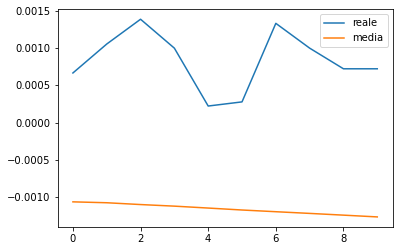

In [ ]:
#plt.plot(r_test.flatten(),label="reale")
#plt.plot(m[a+b:a+b+1].flatten(),label="media")
#plt.legend();

In [ ]:
calcola_mse1(r_test.flatten(),rbarr.flatten())

ValueError: setting an array element with a sequence.

In [ ]:
def MSEbmk(r):
    rBar=np.mean(r)
    h=[ 22, 44, 89, 133, 178, 223, 267, 312, 356, 401]
    emq=np.empty(len(h))
    for i,ii in zip(range(len(r)),range(10)):
        emq[i]=((r[0,ii]-rBar)/rBar)**2#*(1/(len(r)-1))
    return emq

In [ ]:
num/MSEbmk(r_test)

array([9.44661130e-04, 3.70184735e-05, 1.69378158e-04, 1.93044901e-04,
       1.67980224e-04, 1.50480534e-04, 1.61771484e-04, 2.47300725e-04,
       2.60427691e-04, 3.05833888e-04])

In [ ]:
r2LSTMSFT#/MSEbmk(of_data['r'])/100

array([ -5.78618626, -22.51323528,  -2.70050502,  -2.17765061,
        -2.10908353,  -2.16453434,  -1.57268381,  -0.83071732,
        -0.54665271,  -0.24322155])

In [ ]:
num, den

(array([3.98523448e-05, 3.70171032e-05, 1.69349474e-04, 1.93007642e-04,
        1.67952011e-04, 1.50457893e-04, 1.61745318e-04, 2.47239582e-04,
        2.60359886e-04, 3.05740382e-04]),
 array([0.00027045, 0.00087039, 0.00062668, 0.00061331, 0.00052218,
        0.00047613, 0.00041612, 0.00045263, 0.00040269, 0.0003801 ]))